<a href="https://colab.research.google.com/github/bhaveshwadhwani/Advanced-NLP/blob/master/CNN_1d_Comments_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!wget "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/8076/44219/bundle/archive.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1581917585&Signature=spqZ2KWPKe4t73qEgFvtT2UbGr2nJZk54RiarU2Qd00ysby4QB1cxGQtTYk8GZ00bnsUQG%2BiQF5iF7COgFa%2F35I3PY3cUVo5tijp7eIC%2FQiFxjRmTXCgDK4YCReRXpde4NY0ZYtC1jWBEY5oRaRKguUlZoo%2BKa5Y5kSKqYv3lcHL0P%2BgY5tbuGovFrbIxJMt3CSP6WK0pLmhzIeiNPl2GJ41ypqi05ray4VtEo3b%2FLSHAwNvyN6V3zL%2BQavaajfPL%2B%2BnGv53nVxJ9l%2FPatKDvobuIDwEP0C3FCcoZnH9wTDi88y47IvY9cFccICw8K8t2CrD%2Bo%2FWbOazyjTGK%2FcF7Q%3D%3D&response-content-disposition=attachment%3B+filename%3Djigsaw-toxic-comment-classification-challenge.zip"

In [3]:
!wget "http://nlp.stanford.edu/data/glove.6B.zip"

--2020-02-14 05:34:37--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-02-14 05:34:37--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-02-14 05:34:37--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [6]:
!unzip "/content/data.zip"

Archive:  /content/data.zip
  inflating: sample_submission.csv.zip  
  inflating: test.csv.zip            
  inflating: test_labels.csv.zip     
  inflating: train.csv.zip           


In [7]:
!unzip "train.csv.zip"

Archive:  train.csv.zip
  inflating: train.csv               


In [5]:
!unzip "glove.6B.zip"

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [0]:
# https://deeplearningcourses.com/c/deep-learning-advanced-nlp
from __future__ import print_function, division
from builtins import range
# Note: you may need to update your version of future
# sudo pip install -U future

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Model
from sklearn.metrics import roc_auc_score


# Download the data:
# https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge
# Download the word vectors:
# http://nlp.stanford.edu/data/glove.6B.zip

In [9]:
# some configuration
MAX_SEQUENCE_LENGTH = 100
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2
BATCH_SIZE = 128
EPOCHS = 10



# load in pre-trained word vectors
print('Loading word vectors...')
word2vec = {}
with open(os.path.join('glove.6B.%sd.txt' % EMBEDDING_DIM)) as f:
  # is just a space-separated text file in the format:
  # word vec[0] vec[1] vec[2] ...
  for line in f:
    values = line.split()
    word = values[0]
    vec = np.asarray(values[1:], dtype='float32')
    word2vec[word] = vec
print('Found %s word vectors.' % len(word2vec))



# prepare text samples and their labels
print('Loading in comments...')

train = pd.read_csv("train.csv")
sentences = train["comment_text"].fillna("DUMMY_VALUE").values
possible_labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
targets = train[possible_labels].values

Loading word vectors...
Found 400000 word vectors.
Loading in comments...


In [10]:
# convert the sentences (strings) into integers
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(sentences)
sequences = tokenizer.texts_to_sequences(sentences)
# print("sequences:", sequences); exit()


print("max sequence length:", max(len(s) for s in sequences))
print("min sequence length:", min(len(s) for s in sequences))
s = sorted(len(s) for s in sequences)
print("median sequence length:", s[len(s) // 2])


# get word -> integer mapping
word2idx = tokenizer.word_index
print('Found %s unique tokens.' % len(word2idx))

max sequence length: 1400
min sequence length: 0
median sequence length: 35
Found 210337 unique tokens.


In [11]:
# pad sequences so that we get a N x T matrix
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', data.shape)



# prepare embedding matrix
print('Filling pre-trained embeddings...')
num_words = min(MAX_VOCAB_SIZE, len(word2idx) + 1)
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word2idx.items():
  if i < MAX_VOCAB_SIZE:
    embedding_vector = word2vec.get(word)
    if embedding_vector is not None:
      # words not found in embedding index will be all zeros.
      embedding_matrix[i] = embedding_vector



# load pre-trained word embeddings into an Embedding layer
# note that we set trainable = False so as to keep the embeddings fixed
embedding_layer = Embedding(
  num_words,
  EMBEDDING_DIM,
  weights=[embedding_matrix],
  input_length=MAX_SEQUENCE_LENGTH,
  trainable=False
)

Shape of data tensor: (159571, 100)
Filling pre-trained embeddings...



In [12]:
print('Building model...')

# train a 1D convnet with global maxpooling
input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
x = embedding_layer(input_)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(128, 3, activation='relu')(x)
x = GlobalMaxPooling1D()(x)
x = Dense(128, activation='relu')(x)
output = Dense(len(possible_labels), activation='sigmoid')(x)

model = Model(input_, output)
model.compile(
  loss='binary_crossentropy',
  optimizer='rmsprop',
  metrics=['accuracy']
)

Building model...











Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
print('Training model...')
r = model.fit(
  data,
  targets,
  batch_size=BATCH_SIZE,
  epochs=EPOCHS,
  validation_split=VALIDATION_SPLIT
)

Training model...


Train on 127656 samples, validate on 31915 samples
Epoch 1/10
127656/127656 [==============================] - 14s 113us/step - loss: 0.0835 - acc: 0.9731 - val_loss: 0.0770 - val_acc: 0.9739
Epoch 2/10
127656/127656 [==============================] - 6s 49us/step - loss: 0.0672 - acc: 0.9775 - val_loss: 0.0673 - val_acc: 0.9774
Epoch 3/10
127656/127656 [==============================] - 7s 51us/step - loss: 0.0627 - acc: 0.9784 - val_loss: 0.0679 - val_acc: 0.9778
Epoch 4/10
127656/127656 [==============================] - 7s 52us/step - loss: 0.0596 - acc: 0.9794 - val_loss: 0.0746 - val_acc: 0.9774
Epoch 5/10
127656/127656 [==============================] - 6s 49us/step - loss: 0.0576 - acc: 0.9797 - val_loss: 0.0696 - val_acc: 0.9766
Epoch 6/10
127656/127656 [==============================] - 6s 49us/step - loss: 0.0555 - acc: 0.9804 - val_loss: 0.0746 - val_acc: 0.9760
Epoch 7/10
127656/127656 [==============================] - 7s 52us/step - loss: 0.0537 - acc

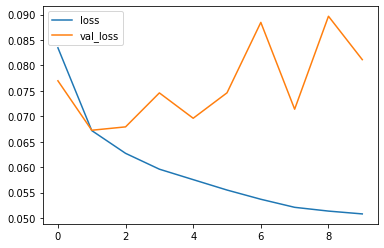

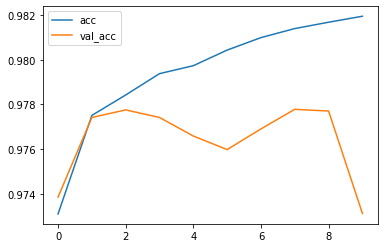

0.9747373398124113


In [14]:
# plot some data
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

# accuracies
plt.plot(r.history['acc'], label='acc')
plt.plot(r.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

# plot the mean AUC over each label
p = model.predict(data)
aucs = []
for j in range(6):
    auc = roc_auc_score(targets[:,j], p[:,j])
    aucs.append(auc)
print(np.mean(aucs))

## While we see good fit and shows high accuracy on train data but using validation data we can understand there is overfit on train data

In [0]:
# TO-DO Reduce Overfitting : Try Adding some regulariazation,Dropout 